In [27]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.model_selection import (TimeSeriesSplit)
from sklearn.linear_model import (LinearRegression, BayesianRidge, Lasso)
from sklearn.metrics import (mean_squared_error)
from sklearn.decomposition import (PCA)
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


This version contains the application of regression models after PCA dimensionality reduction, with k folds cross validation with blocking.

1. Get and preprocess data

In [28]:
def rename_columns(old_name):
    if old_name[-5:] == '10-10':
        new_name = old_name[:-5] + '10' 
    elif old_name[-5:] == '20-20':
        new_name = old_name[:-5] + '20' 
    else:
        new_name = old_name
    return new_name

def get_data(company):
    daily = pd.read_csv('./data/daily_{}.csv'.format(company))
    open_ind = pd.read_csv('./data/open_ind_{}.csv'.format(company))
    close_ind = pd.read_csv('./data/close_ind_{}.csv'.format(company))
    high_ind = pd.read_csv('./data/high_ind_{}.csv'.format(company))
    low_ind = pd.read_csv('./data/low_ind_{}.csv'.format(company))

    open_ind.rename(columns=rename_columns, inplace=True)
    close_ind.rename(columns=rename_columns, inplace=True)
    high_ind.rename(columns=rename_columns, inplace=True)
    low_ind.rename(columns=rename_columns, inplace=True)
    
    return daily, open_ind, close_ind, high_ind, low_ind

In [29]:
def get_process_data(company,timelag=1):
    data = get_data(company) #(daily, open_ind, close_ind, high_ind, low_ind)
    X_list = []
    y_list = []
    for i in range(len(price_types)):
        combined = pd.concat([data[0],data[i+1]],axis=1)
        combined = combined[combined.isnull().any(axis=1)==False] # drop any columns that has NA, some indicators do not go further back, should start around the year 2000
        combined.rename({'Unnamed: 0': 'Date','1. open':'open', '2. high': 'high', '3. low': 'low', '4. close': 'close','6. volume': 'volume', '7. dividend amount': 'dividend'}, axis='columns',inplace=True)
        combined.drop('5. adjusted close',axis=1, inplace=True)
        combined.drop('8. split coefficient',axis=1, inplace=True)
        combined.set_index('Date',inplace=True)
        combined = combined.iloc[::-1]
        
        X = combined.iloc[:,4:]
        X_list.append(X)
        y = combined[[price_types[i]]]
        y_list.append(y)
        
    return X_list,y_list

Standardize or scale using standardScaler and MinMaxScaler, perform PCA, 

In [30]:
def standardize_scale(dif_scaler, X_train, X_test, y_train, y_test):
    scaler_X=dif_scaler
    X_train_standardize = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_standardize = pd.DataFrame(scaler_X.transform(X_test),  columns=X_test.columns, index=X_test.index)
    
    scaler_Y=dif_scaler
    y_train_standardize = pd.DataFrame(scaler_Y.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
    y_test_standardize = pd.DataFrame(scaler_Y.transform(y_test), columns=y_test.columns, index=y_test.index)

    X_train_standardize.insert(0,'bias',1)
    X_test_standardize.insert(0,'bias',1)
    
    return [X_train_standardize, X_test_standardize, y_train_standardize, y_test_standardize], scaler_Y

In [31]:
# if n_steps=5, use 1,2,3,4,5th day indicator data to predict 6th day prices
def reshape_for_regression(X, y, n_steps=5):
    X_result = []
    s = X.shape[0] - n_steps
    for i in range(s):
        temp = []
        for j in range(n_steps):
            temp += list(X.iloc[i+j,:].values)
        X_result.append(temp)     # n_features x n_steps elements total in one row instead of just n_features elements
    
    y_result = y.iloc[n_steps:,:]
    return pd.DataFrame(X_result, index=X.iloc[n_steps:,:].index), y_result

In [32]:
def reshape_data(data, n_steps=5):
    X_train, X_test, y_train, y_test = data
    
    a,b = reshape_for_regression(X_train, y_train, n_steps)
    c,d = reshape_for_regression(X_test, y_test, n_steps)
    
    return a,c,b,d

In [33]:
# perform PCA to reduce dimension so reduced features can explain 95% of variance
def perform_PCA(X_train, X_test, threshold=0.95):
    pca = PCA(n_components=threshold)
    pca.fit(X_train)
    reduced_X_train = pca.transform(X_train)
    reduced_X_test = pca.transform(X_test)
    return pd.DataFrame(reduced_X_train, index=X_train.index), pd.DataFrame(reduced_X_test, index=X_test.index)

This version has "blocking time series split"

In [34]:
# k_folds for number of splits for cross validation
# n_steps for number of past data used in prediction (if 5, use 1,2,3,4,5th day data to predict 6th day)

def k_folds_and_standardize(X_list,y_list,k_folds=5, n_steps=5):
    ts_kfold = TimeSeriesSplit(k_folds)
    standardized_all_splits_by_price_type = []
    min_max_scaler_all_splits_by_price_type = []
    standardized_scalers_list = []
    minmax_scalers_list = []
    X_train_lists = []
    
    for index in range(len(X_list)): #open,close,high,low
        X=X_list[index]
        y=y_list[index]
        standardized_splits_by_price_type = []
        min_max_scaler_splits_by_price_type = []
        
        standardized_scalers = []
        minmax_scalers = []
        start = 0
        each_fold_size = X.shape[0]//k_folds
        X_train_list = []
        
        
#         Time Series Split - k fold
        for train_index, test_index in ts_kfold.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
#         for i in range(k_folds):
            
#             # blocking time series split
#             if i == 0:
#                 fold_size = X.shape[0]%k_folds + each_fold_size
#             else:
#                 fold_size = each_fold_size
#             training_size = math.ceil(fold_size*0.75)

#             X_train, X_test = X.iloc[start:start+training_size,:], X.iloc[start+training_size:start+fold_size, :]
#             y_train, y_test = y.iloc[start:start+training_size,:], y.iloc[start+training_size:start+fold_size, :]
#             start += fold_size
            
            # reshape with past n_steps days values
            X_train, X_test, y_train, y_test = reshape_data([X_train, X_test, y_train, y_test ], n_steps)
            
            # standardize
            standardized_data, scalers = standardize_scale(StandardScaler(), X_train, X_test, y_train, y_test)
            X_train, X_test, y_train, y_test = standardized_data
            X_train, X_test = perform_PCA(X_train, X_test)
            
            standardized_splits_by_price_type.append([X_train, X_test, y_train, y_test])
            standardized_scalers.append(scalers)  # only save scalers for Y to inverse_transform the predicted result
            
            X_train_list.append(X_train)
#             min_max_data, scalers = standardize_scale(MinMaxScaler(feature_range=(0,1)), X_train, X_test, y_train, y_test)
#             X_train, X_test, y_train, y_test = min_max_data
#             X_train, X_test = perform_PCA(X_train, X_test)
            
#             min_max_scaler_splits_by_price_type.append([X_train, X_test, y_train, y_test])
#             minmax_scalers.append(scalers)  # only save scalers for Y to inverse_transform the predicted result
            
        standardized_all_splits_by_price_type.append(standardized_splits_by_price_type)
#         min_max_scaler_all_splits_by_price_type.append(min_max_scaler_splits_by_price_type)
        
        standardized_scalers_list.append(standardized_scalers)
#         minmax_scalers_list.append(minmax_scalers)
        X_train_lists.append(X_train_list)
        
#     min_max_scaler_all_splits_by_price_type, , minmax_scalers_list
    return standardized_all_splits_by_price_type, standardized_scalers_list, X_train_lists
# result will be of size (4, k_folds, 4) The outer four is the type of prices, open close high low. The inner four is the training and testing sets of X and y.

In [35]:
def linear_regression(X_train, X_test, y_train, y_test, scaler):
    linear_reg = LinearRegression().fit(X_train,y_train)
    y_predict = linear_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse

In [36]:
def bayesian_ridge_regression(X_train, X_test, y_train, y_test, scaler):
    bay_reg = BayesianRidge().fit(X_train,y_train.values.ravel())
    y_predict = bay_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [37]:
def lasso_regression(X_train, X_test, y_train, y_test, scaler):
    lasso_reg = Lasso().fit(X_train,y_train.values.ravel())
    y_predict = lasso_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [38]:
def decision_tree_regression(X_train, X_test, y_train, y_test, scaler):
    ds_reg = DecisionTreeRegressor().fit(X_train,y_train)
    y_predict = ds_reg.predict(X_test)

    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse

In [39]:
def random_forest_regression(X_train, X_test, y_train, y_test, scaler):
    rf_reg = RandomForestRegressor(random_state=0)
    rf_reg.fit(X_train, y_train)
    y_predict = rf_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [40]:
def support_vector_regression(X_train, X_test, y_train, y_test, scaler):
    svr_reg = SVR().fit(X_train, y_train)
    y_predict = svr_reg.predict(X_test)
    
    y_test_inverse = scaler.inverse_transform(y_test)
    y_predict_inverse = scaler.inverse_transform(y_predict)
    rmse = mean_squared_error(y_test_inverse, y_predict_inverse, squared=False)
    y_predict_inverse = pd.DataFrame(y_predict_inverse, index = y_test.index)
    return y_predict_inverse, rmse  

In [41]:
def implement_models(standardized_data, scalers, model_types, k_folds=5):
    open_RMSEs = pd.DataFrame()
    close_RMSEs = pd.DataFrame()
    high_RMSEs = pd.DataFrame()
    low_RMSEs = pd.DataFrame()

    open_predictions = pd.DataFrame()
    close_predictions = pd.DataFrame()
    high_predictions = pd.DataFrame()
    low_predictions = pd.DataFrame()
    
    open_X_train_list = []
    close_X_train_list = []
    high_X_train_list = []
    low_X_train_list = []

    for i in range(len(price_types)):
        for model_type in model_types:
            linear_regression_prediction = []
            exec(model_type + "_rmse_list = []")
            exec(model_type + "_prediction = []")

        for j in range(k_folds):
            X_train, X_test, y_train, y_test = standardized_data[i][j]
            scaler = scalers[i][j]
            for model_type in model_types:
                exec(model_type +"_predict, " + model_type + '_rmse = ' + model_type +"(X_train, X_test, y_train, y_test, scaler)")
                exec(model_type +"_prediction.append(" + model_type + "_predict)")
                exec(model_type +"_rmse_list.append(" + model_type + "_rmse)")
        
            exec(price_types[i] +"_X_train_list.append(X_train)")
            
        for model_type in model_types:
            exec(price_types[i] + "_RMSEs['" + model_type +"'] = " + model_type + "_rmse_list")
            exec(price_types[i] + "_predictions['" + model_type +"'] = " + model_type + "_prediction")
    
    rmse = [open_RMSEs, close_RMSEs, high_RMSEs, low_RMSEs]
    prediction = [open_predictions, close_predictions, high_predictions, low_predictions]
    X_train_lists = [open_X_train_list, close_X_train_list, high_X_train_list, low_X_train_list]
    return rmse, prediction

In [42]:
# main code
def regression_prediction(companies, price_types, model_types, k_folds = 5, n_steps = 5):
    for company in companies:
        X_list,y_list = get_process_data(company)
        standardized, std_scalers, X_train_lists = k_folds_and_standardize(X_list,y_list, k_folds, n_steps)
        rmse, prediction = implement_models(standardized, std_scalers, model_types, k_folds)
        return rmse, prediction, standardized, y_list, X_train_lists

In [43]:
def prepare_to_plot(prediction, X_train_lists, y_list, price_type, model_type, k_fold_idx):
    price_type_idx = price_types.index(price_type)

    y_predict = prediction[price_type_idx][model_type][k_fold_idx]
    predict_idx = prediction[price_type_idx][model_type][k_fold_idx].index
    y_actual = y_list[price_type_idx].loc[predict_idx]

    train_idx = X_train_lists[price_type_idx][k_fold_idx].index
    y_before = y_list[price_type_idx].loc[train_idx]
    
    y_before.index = pd.to_datetime(y_before.index, format="%Y-%m-%d")
    y_actual.index = pd.to_datetime(y_actual.index, format="%Y-%m-%d")
    y_predict.index = pd.to_datetime(y_predict.index, format="%Y-%m-%d")
    
    return y_before, y_actual, y_predict

In [44]:
def plot(prediction, X_train_lists, y_list, company, price_type, model_type, k_fold_idx):
    y_before, y_actual, y_predict = prepare_to_plot(prediction, X_train_lists, y_list, price_type, model_type, k_fold_idx)
    
    fig, ax = plt.subplots()

    plt.plot(y_before)
    plt.plot(y_predict)
    plt.plot(y_actual)

    locator = mdates.AutoDateLocator(maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.title("Stock {} Price forecast for {} using {} with k-folds cross validation without blocking".format(price_type, company, model_type))
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")

    plt.show()
    
    fig.savefig('./image/{}_{}_price_forcast_using_{}_k_fold_without_blocking.png'.format(company, price_type, model_type))

In [45]:
companies = ['IBM','AAPL','JNJ']
price_types = ['open', 'close','high','low']
model_types = ['linear_regression','bayesian_ridge_regression', 'lasso_regression','decision_tree_regression', 'random_forest_regression', 'support_vector_regression']

In [46]:
price_type = "open"
k_folds=10
n_steps=5

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

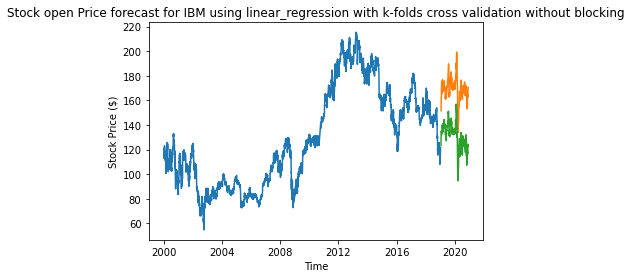

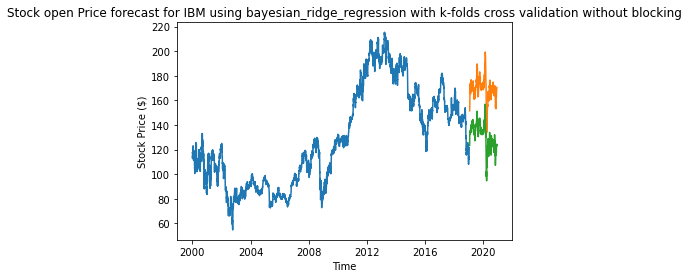

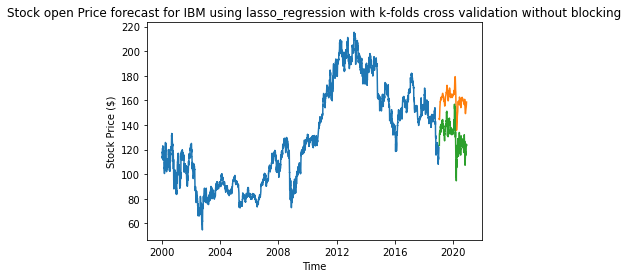

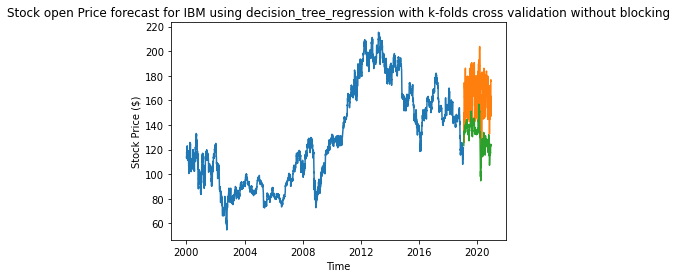

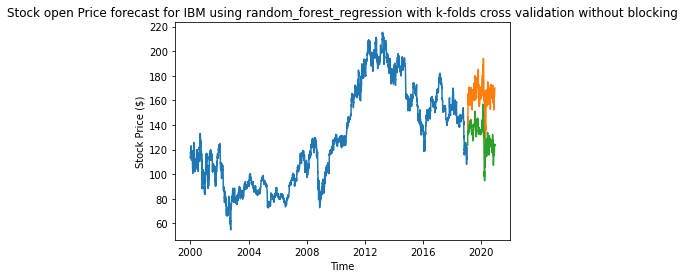

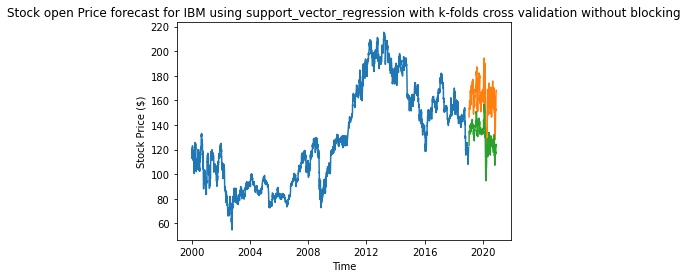

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

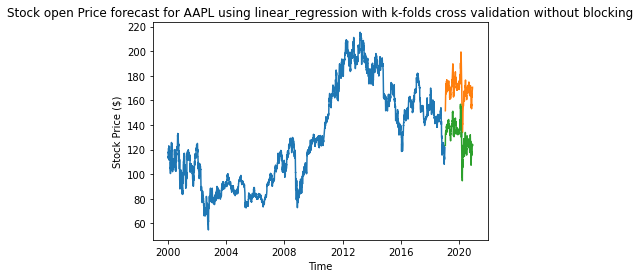

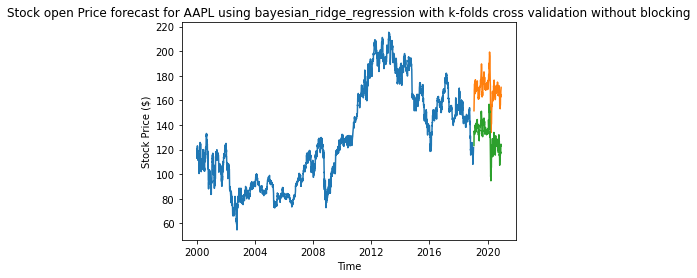

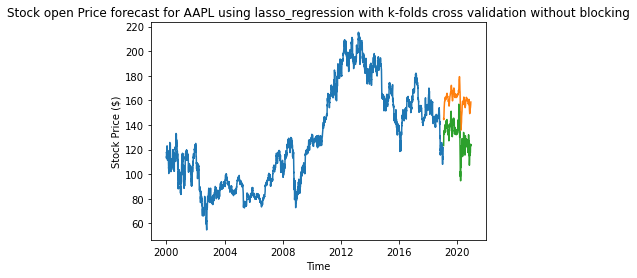

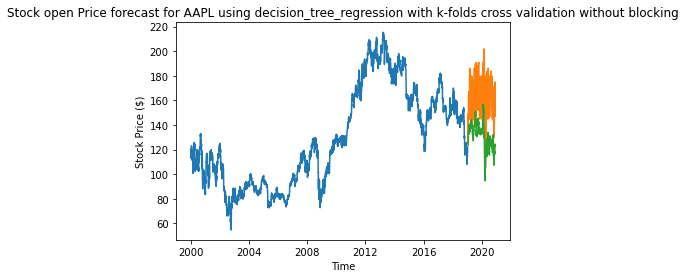

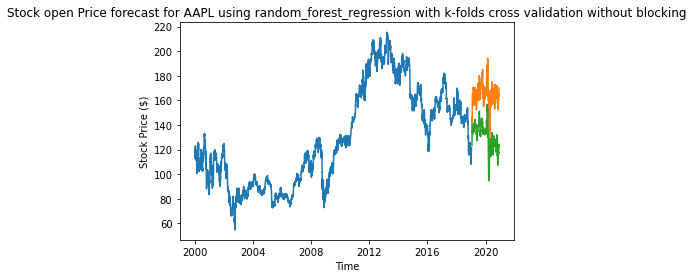

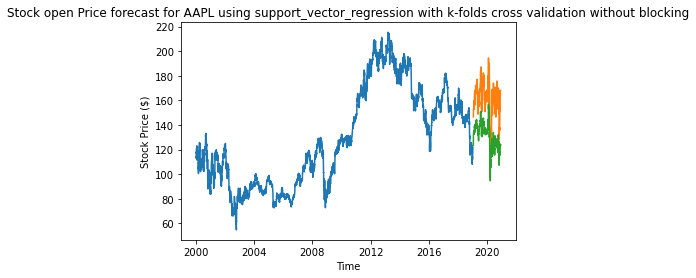

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\YING\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YING\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array

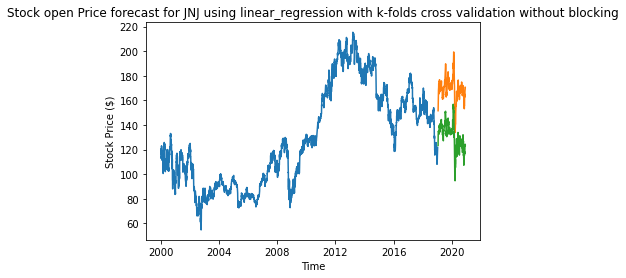

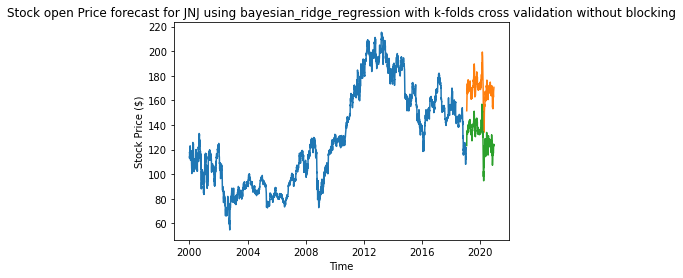

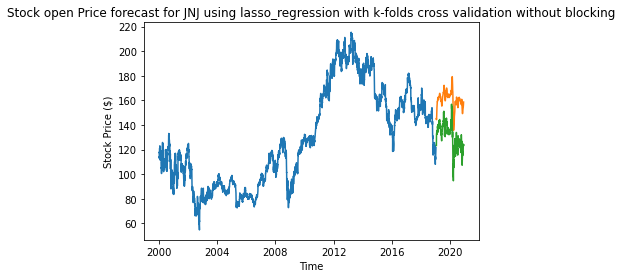

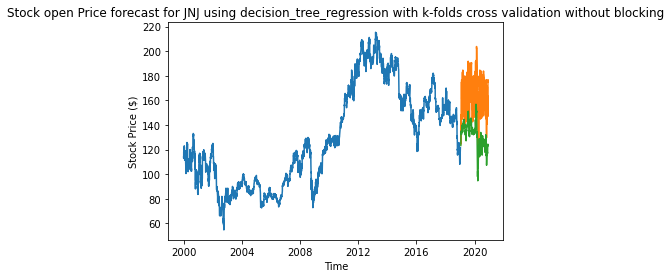

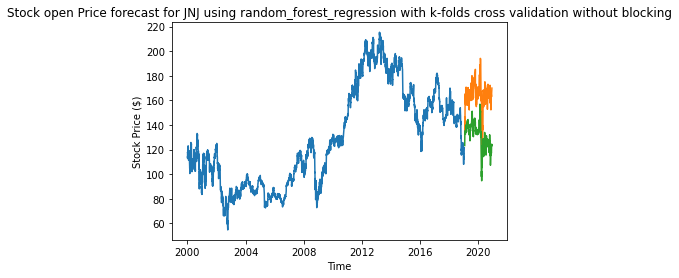

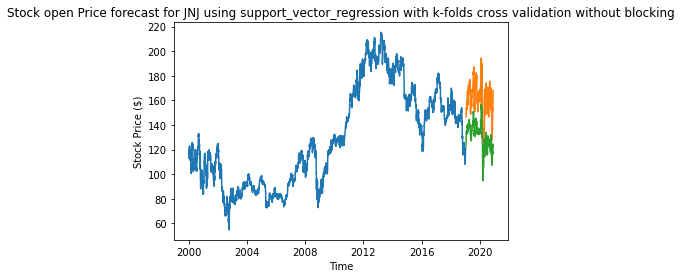

In [47]:
all_rmse = dict()
all_prediction = dict()
for company in companies:
    rmse, prediction, standardized, y_list, X_train_lists = regression_prediction(companies, price_types, model_types, k_folds, n_steps)
    all_rmse[company] = rmse
    all_prediction[company] = prediction
    for model_type in model_types:
        plot(prediction, X_train_lists, y_list, company, price_type, model_type, k_fold_idx = k_folds-1)
pd.DataFrame(all_prediction).to_csv('./result/regression_no_blocking_prediction_PCA_{}.csv'.format(price_type))
pd.DataFrame.from_records([all_rmse]).to_csv('./result/regression_no_blocking_rmse_PCA_{}.csv'.format(price_type))

In [48]:
selected='IBM'

In [57]:
print("RMSEs for open price prediction")
LSTM_data = pd.read_csv('./temp/LSTM_no_blocking_rmse.csv')
no_blocking_rmse = all_rmse[selected][0]
no_blocking_rmse['LSTM'] = LSTM_data['open']
no_blocking_rmse.loc['mean'] = no_blocking_rmse.mean()
no_blocking_rmse.columns = ['linear_reg', 'bayesian_ridge_reg', 'lasso_reg', 'decision_tree_reg', 'random_forest_reg', 'support_vector_reg', 'LSTM']
no_blocking_rmse

RMSEs for open price prediction


,linear_reg,bayesian_ridge_reg,lasso_reg,decision_tree_reg,random_forest_reg,support_vector_reg,LSTM
0,4.808667,4.888521,11.106014,17.408132,17.483984,22.129125,13.876827
1,2.808404,2.801274,3.987724,7.786797,4.958296,4.456159,2.866125
2,3.101628,3.088688,2.980014,5.158098,3.653026,3.080102,2.010821
3,6.495706,6.500080,5.163131,10.160646,7.587659,10.179928,10.744795
4,13.141895,13.120353,3.175249,18.762084,18.259282,33.650716,7.194653
5,6.281452,6.241676,23.352842,29.532666,29.978575,56.429829,4.492716
6,5.765021,5.755637,15.123856,10.890031,7.693399,7.075891,4.440449
7,15.202643,15.195535,8.400180,11.456419,11.153010,11.324728,11.919901
8,21.318324,21.317838,15.665133,19.579172,17.881335,18.570012,20.087404
9,38.806086,38.774088,30.220179,36.295280,35.456723,31.534919,26.415850


In [50]:
print("RMSEs for close price prediction")
all_rmse[selected][1]

RMSEs for close price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,5.419999,5.513424,11.228263,18.946895,15.821266,21.945442
1,2.772806,2.762204,4.340307,6.898584,4.532017,4.407016
2,3.071094,3.055613,3.449000,5.860554,3.994126,3.157156
3,6.465571,6.470780,5.351381,10.273948,7.562306,10.470835
4,12.836098,12.812190,3.955006,19.402627,18.193583,34.234480
5,6.551442,6.510844,23.502617,31.936980,31.652171,56.191719
6,5.705714,5.696624,15.394106,10.457689,8.670581,7.428828
7,15.082567,15.075695,8.466207,12.508718,11.384881,10.986518
8,21.315211,21.315145,15.598774,18.493378,17.724332,18.119008
9,38.821706,38.791402,30.247502,38.274577,35.760610,32.025156


In [51]:
print("RMSEs for high price prediction")
rmse[2]

RMSEs for high price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,4.768738,4.906190,11.338458,17.742358,17.427213,22.293969
1,2.627253,2.619939,4.432109,8.135433,4.642313,4.712964
2,2.898804,2.886820,3.276110,5.625144,3.434163,3.273059
3,6.414389,6.419239,5.144939,7.921877,7.363742,9.977023
4,13.225187,13.204619,3.391210,18.698018,18.179139,33.572218
5,6.647477,6.609397,23.388810,30.280624,30.512753,56.323619
6,5.953004,5.943481,15.233988,9.031450,7.648859,7.125234
7,15.523604,15.515817,8.501249,12.343627,11.248671,11.721004
8,21.499715,21.499499,15.773207,18.030927,17.987416,18.273552
9,38.720978,38.692147,30.344187,38.230135,35.537903,31.837204


In [52]:
print("RMSEs for low price prediction")
all_rmse[selected][3]

RMSEs for low price prediction


,linear_regression,bayesian_ridge_regression,lasso_regression,decision_tree_regression,random_forest_regression,support_vector_regression
0,4.374289,4.503425,10.917984,18.900261,14.902961,20.465606
1,2.751670,2.745328,4.110626,7.539827,4.533549,4.053798
2,3.106778,3.091606,3.278855,6.059529,3.790220,3.180891
3,6.366523,6.371187,5.333021,8.912510,7.218675,10.308025
4,12.777092,12.754449,4.070228,18.652770,18.162246,34.326714
5,6.161949,6.124133,23.684195,29.733689,30.201595,55.680385
6,5.546591,5.538487,15.372952,10.734110,8.471007,6.974241
7,15.224043,15.216758,8.337062,13.292464,11.254029,11.040174
8,21.109199,21.109166,15.487277,20.518759,17.875217,17.715233
9,38.521096,38.492616,30.122694,36.803815,34.730982,31.615728
